# Medicaid and Medicare distribution in taxdata

Extreme benefit amounts are present in taxdata but don't seem expected based on [C-TAM documentation](https://docs.google.com/document/d/1OoWr18ZZkXC9jRI3PHkvKncfCK_BGrTez4syXBCMCK8/edit#heading=h.91rtosbtbpbd).

*Data: CPS | Tax year: 2014 | Author: Max Ghenis | Date run: 2018-04-10 *

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.18.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

### Utilities

In [6]:
def weight(df, col):
    return df[col] * df.s006

def weighted_sum(df, col):
    return weight(df, col).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

## Generate data

In [7]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
# calc.advance_to_year(2018)
calc.calc_all()

In [8]:
tu = calc.dataframe(['s006', 'mcaid_ben', 'mcare_ben', 'XTOT'])

## Preprocessing

In [9]:
tu['XTOT_s006'] = weight(tu, 'XTOT')

In [10]:
tu['mcaid_ben_pp'] = tu.mcaid_ben / tu.XTOT
tu['mcare_ben_pp'] = tu.mcare_ben / tu.XTOT

In [11]:
tu.sort_values(by='mcaid_ben_pp', inplace=True)
tu['pct_cumsum_mcaid'] = tu.XTOT_s006.cumsum() / tu.XTOT_s006.sum()
tu['pctile_cumsum_mcaid'] = (100 * tu.pct_cumsum_mcaid).round()
tu.sort_values(by='mcare_ben_pp', inplace=True)
tu['pct_cumsum_mcare'] = tu.XTOT_s006.cumsum() / tu.XTOT_s006.sum()
tu['pctile_cumsum_mcare'] = (100 * tu.pct_cumsum_mcare).round()

In [12]:
mcaid_dist = (
    tu.groupby('pctile_cumsum_mcaid')['mcaid_ben_pp'].mean().reset_index())
mcare_dist = (
    tu.groupby('pctile_cumsum_mcare')['mcare_ben_pp'].mean().reset_index())

## Analysis

### Totals

In [13]:
round(weighted_sum(tu, 'mcaid_ben') / 1e9)

368.0

In [14]:
round(weighted_sum(tu, 'mcare_ben') / 1e9)

575.0

### Extremes

In [15]:
tu.mcaid_ben_pp.max()

454619.0

In [16]:
tu.mcare_ben_pp.max()

691961.0

In [17]:
tu[tu.mcaid_ben_pp == tu.mcaid_ben_pp.max()]

,s006,mcaid_ben,mcare_ben,XTOT,XTOT_s006,mcaid_ben_pp,mcare_ben_pp,pct_cumsum_mcaid,pctile_cumsum_mcaid,pct_cumsum_mcare,pctile_cumsum_mcare
326681,598.0,454619.0,0.0,1.0,598.0,454619.0,0.0,1.0,100.0,0.1,10.0
340672,435.0,454619.0,0.0,1.0,435.0,454619.0,0.0,1.0,100.0,0.7,70.0


In [18]:
tu[tu.mcare_ben_pp == tu.mcare_ben_pp.max()]

,s006,mcaid_ben,mcare_ben,XTOT,XTOT_s006,mcaid_ben_pp,mcare_ben_pp,pct_cumsum_mcaid,pctile_cumsum_mcaid,pct_cumsum_mcare,pctile_cumsum_mcare
249876,877.0,0.0,691961.0,1.0,877.0,0.0,691961.0,0.24,24.0,1.0,100.0


### CDFs

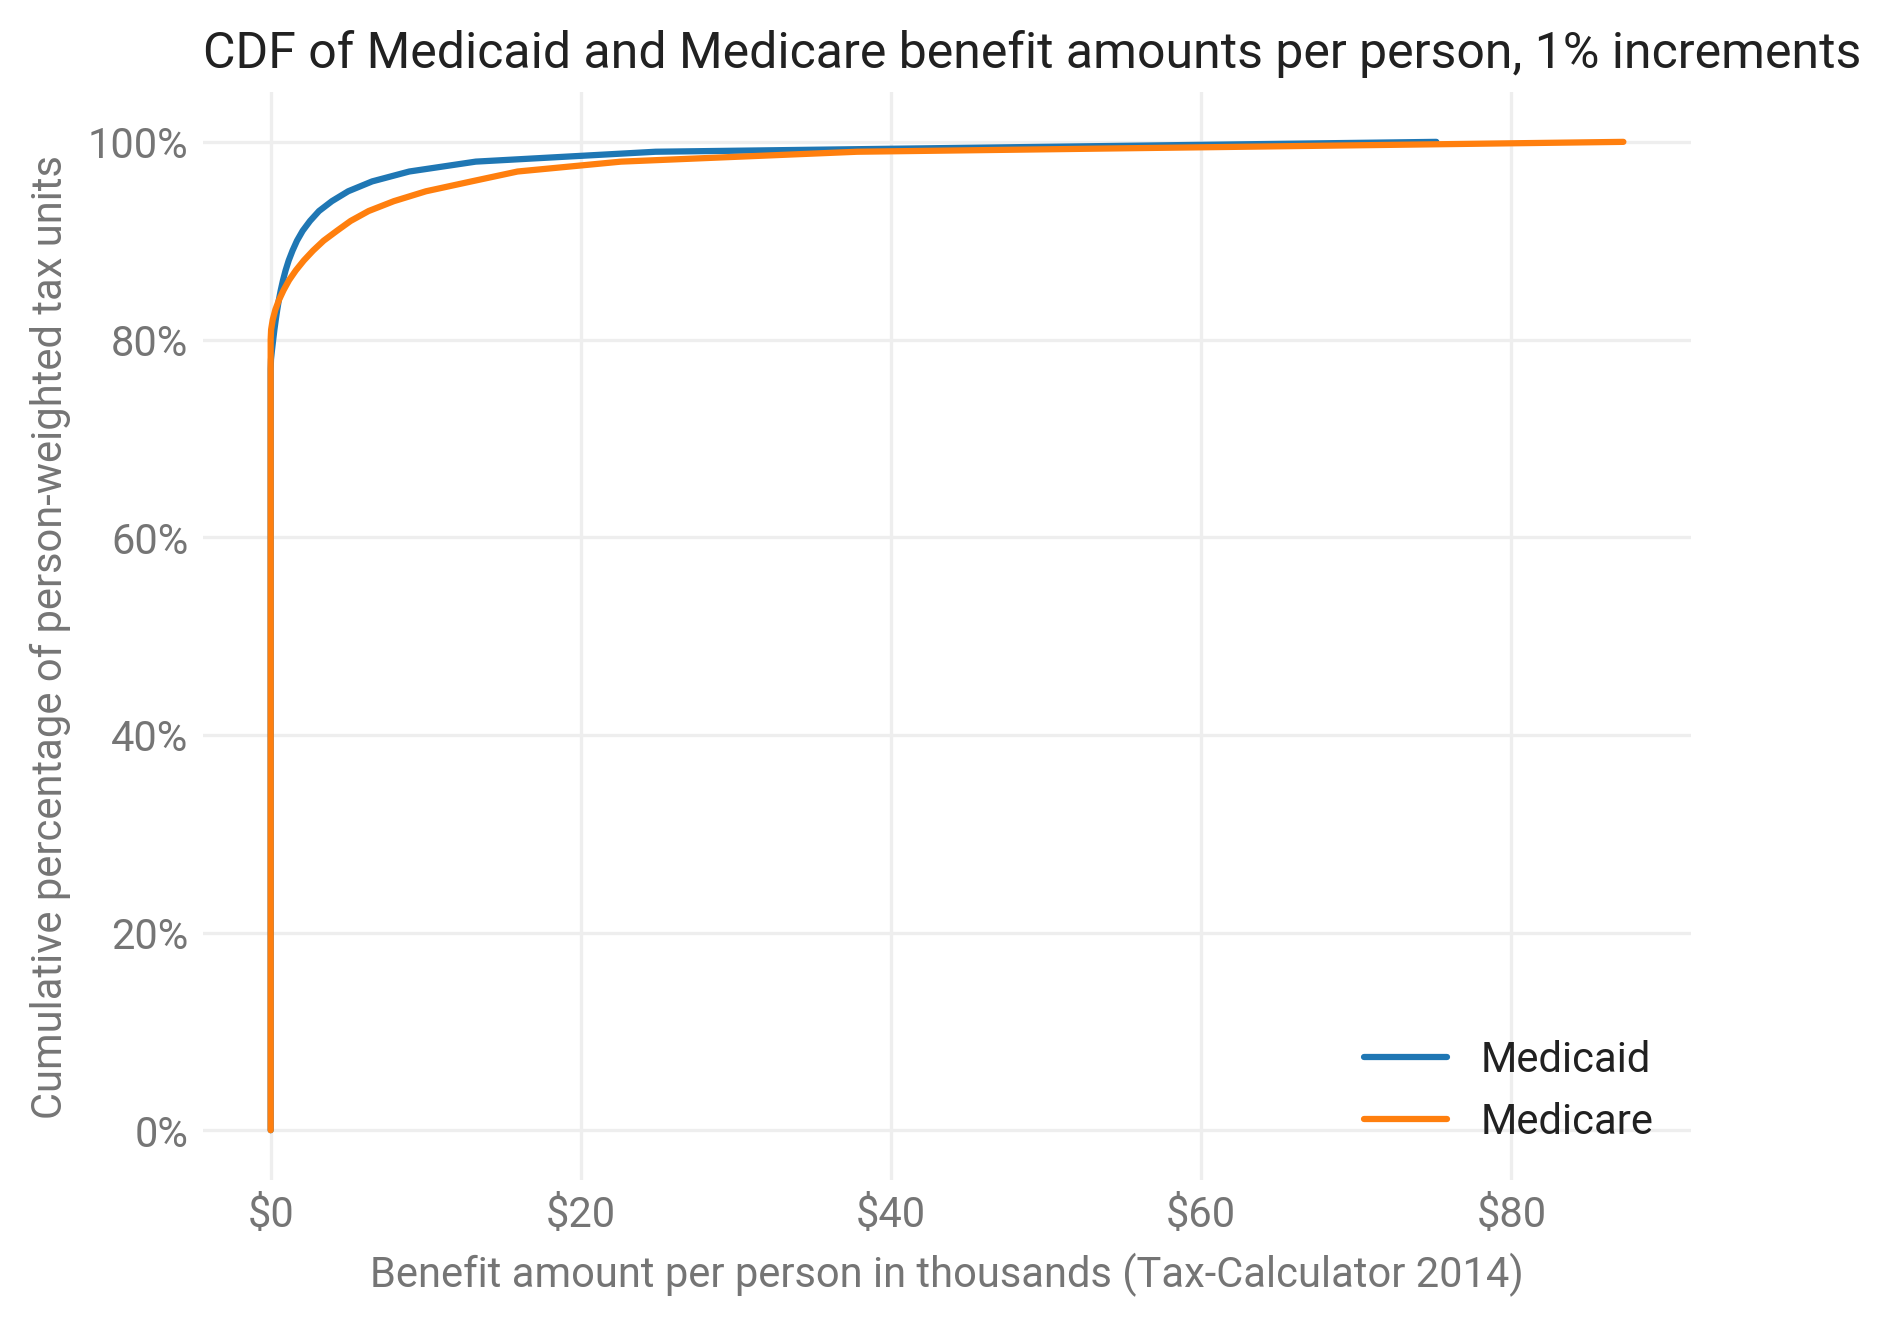

In [19]:
ax = mcaid_dist.plot(x='mcaid_ben_pp', y='pctile_cumsum_mcaid')
mcare_dist.plot(x='mcare_ben_pp', y='pctile_cumsum_mcare', ax=ax)
ax.legend(['Medicaid', 'Medicare'])
ax.grid(color='#eeeeee')
ax.set(xlabel='Benefit amount per person in thousands (Tax-Calculator 2014)',
       ylabel='Cumulative percentage of person-weighted tax units')
sns.despine(left=True, bottom=True)
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1000))))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('CDF of Medicaid and Medicare benefit amounts per person, ' +
          '1% increments', loc='left')
plt.show()